# Calculating Gene expression. 

This script calculates gene expression in raw read counts, RPKM and TPM (So we are looking at the raw reads and a normalizsed measure of gene expression) using matched samples of RNA-seq and ribosome profiling data. 


Gene expression – or, more broadly, read density over from any high-throughput sequencing experiment over any genomic region – can be calculated easily in an interactive Python session.

Here I am caclulating read density over coding regions.

## Importing packages and defining the path

In [1]:
import copy
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use("ggplot")
from plastid import *
from plastid.plotting.plots import *

In [37]:
data_path = "/Users/keeganflanagan/Desktop/Khanh_position/genomes_and_samples/Fly/"
save_path = "/Users/keeganflanagan/Desktop/Khanh_position/Data/TE_tables/"

## Defining Functions

In [13]:
def variable_threeprime_map_function(alignments,segment,p_offsets):
        '''
        This function is used to map read alignments to the location of the ribosomal p-site 
        from their 3' end. The offsets to use for each read length are specified by file
        generated using RiboWaltz.

        alignments:
            Information on the genome alignment of an individual read which is passed 
            to the function from a BamGenome array created by plastid. 

        segment:
            Information on the individual read segment which is passed 
            to the function from a BamGenome array created by plastid. 

        p_offsets:
            A pandas dataframe that has been loaded into the python environmemt.
            This dataframe should follow this template. 
                length          P_offsets
                 28              12
                 29              12
                 30              13
                ...             ...
        '''
        reads_out = []
        count_array = numpy.zeros(len(segment))
        for read in alignments: 
            for length, offset in zip(p_offsets["length"],p_offsets["p_offset"]): 
                if length != len(read.positions):
                    continue # skip read if it is not the length we are currently offsetting.

             # count offset 3' to 5' if the `segment` is on the plus-strand
             # or is unstranded
                if segment.strand == "+":
                    p_site = read.positions[-offset - 1]
                elif segment.strand == ".":
                    p_site = read.positions[-offset - 1]
             # count offset from other end if `segment` is on the minus-strand
                elif segment.strand == "-":
                    p_site = read.positions[offset]

                if p_site >= segment.start and p_site < segment.end:
                    reads_out.append(read)
                    count_array[p_site - segment.start] += 1
        return reads_out, count_array

In [14]:
def VariableThreePrimeMapFactory(p_offsets):
    '''
    BamGenome array objects will only be able to pass the alignments and segment
    arguments to the variable_threeprime_map_function. This wrapper allows me to
    also specify the offset that needs to be passed to the function. 
    '''
    def new_func(alignments,segment):
        return variable_threeprime_map_function(alignments,segment,p_offsets=p_offsets)

    return new_func

## Loading in the data

Open the read alignments, storing each dataset in a BAMGenomeArray:

In [8]:
my_datasets = { "ribosome_profiling" : data_path + "dmel_control_RPF_2_Aligned.sortedByCoord.out.bam",
                "RNA-seq"            : data_path +"dmel_control_RNA_2_Aligned.sortedByCoord.out.bam",
              }

my_datasets = { K : BAMGenomeArray(V) for K,V in my_datasets.items() }

Next, we tell the BAMGenomeArrays which mapping rule to use. We will use a custom built function to apply 3' end mapping to the ribosomal p-site. 

In [15]:
# Load in the table of P-site offsets. 
p_offsets=pd.read_csv("/Users/keeganflanagan/Desktop/Khanh_position/control_RPF_2_p_offsets", sep="\t")

# Map the ribosome profiling alignments to the p-site. 
my_datasets["ribosome_profiling"].set_mapping(VariableThreePrimeMapFactory(p_offsets=p_offsets))

We will map the RNA-seq data along the entire length of each read alignment. Each position in each alignment will be attributed 1.0/ℓ, where ℓ is the length of the read alignment. CenterMapFactory() can do this for us:

In [16]:
my_datasets["RNA-seq"].set_mapping(CenterMapFactory())

In [5]:
gtf_reads=list(GTF2_TranscriptAssembler(open(data_path + "Drosophila_melanogaster.BDGP6.32.103.gtf"),return_type=Transcript))

Now, we need to create a place to hold our data. We’ll use dictionary of lists. The call to copy.deepcopy() on the empty list is necessary to prevent all of these dictionary keys from pointing to the same list, which is a weird side effect of the order in which things are evaluated inside comprehensions:

Once we have created an empty dictionary of lists to hold our data, we’re ready to start calculating are measurements of transcript expression. We’ll use nested for loops to count expression of each transcript. Note that the code below takes about 1 hour to run. 

In [17]:
# we will count gene sub-regions in addition to entire genes
region = ("CDS")

# we will calculate both total counts and RPKM
metrics = ("counts","rpkm","rpk")

# create an empty list for each sample, region, and metric
my_data = { "%s_%s" % (SAMPLE,METRIC) : copy.deepcopy([])\
                                                  for SAMPLE in my_datasets.keys()\
                                                  for METRIC in metrics }

# add a list to our dictionary of lists to store transcript IDs
my_data["transcript_ID"] = []
my_data["gene_ID"] = []

for transcript in gtf_reads:

    # Only choose transcripts from protein coding genes. 
    if transcript.attr["gene_biotype"] == "protein_coding" :
        
        # First, save ID of transcript we are evaluating
        my_data["transcript_ID"].append(transcript.get_name())
        my_data["gene_ID"].append(transcript.attr["gene_name"])

        # Iterate over each sample, getting the counts over each region
        for sample_name, sample_data in my_datasets.items():
            # transcript.get_counts() fetches a list of counts at each position
            # here we just want the sum
            counts = sum(transcript.get_counts(sample_data))
            rpk   = float(counts)/(transcript.length/1000)
            rpkm   = float(counts) / transcript.length * 1000 * 1e6 / sample_data.sum()
            my_data["%s_counts" % (sample_name)].append(counts)
            my_data["%s_rpk"   % (sample_name)].append(rpk)
            my_data["%s_rpkm"   % (sample_name)].append(rpkm)

In [18]:
# convert to Dataframe
df = pd.DataFrame(my_data)

In [34]:
# Rearranging Column names to make something more readable. 
cols = ['transcript_ID', 'gene_ID', 'translation_efficiency','ribosome_profiling_tpm',
        'RNA-seq_tpm','ribosome_profiling_counts','RNA-seq_counts',
        'ribosome_profiling_rpkm', 'RNA-seq_rpkm', 'ribosome_profiling_rpk', 
       'RNA-seq_rpk']
df = df[cols]

In [19]:
#Calculate tpm using rpk from our new dataframe. 
for sample_name, sample_data in my_datasets.items():
    per_m_s = sum(df["%s_rpk"   % (sample_name)])/1e6
    df["%s_tpm" % (sample_name)] = (df["%s_rpk"   % (sample_name)])/per_m_s

# Estimating and plotting translation efficiency
Translation efficiency is a measurement of how much protein is made from a single mRNA. Translation efficiency thus reports specifically on the translational control of gene expression.

Translation efficiency can be estimated by normalizing an mRNA’s translating ribosome density (in RPKM, as measured by ribosome profiling) by the mRNA’s abundance (in RPKM, measured by RNA-Seq) ([IGNW09]).

Making this estimate from the calculations above is simple:

In [20]:
df["translation_efficiency"] = df["ribosome_profiling_tpm"] / df["RNA-seq_tpm"]

The text files may be re-loaded for further analysis, or plotted. For example, to plot the RPKM measurements for translation (ribosome profiling) and transcription (RNA-seq) against each other:

Text(0, 0.5, 'Translation (tpm of footprints over CDS)')

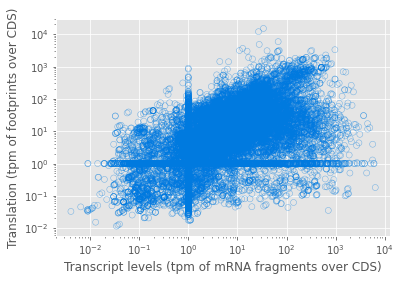

In [21]:
%matplotlib inline
my_figure = plt.figure()
plt.loglog() # log-scaling makes it easier

# make a copy of dataframe for plotting
# this is because 0-values cannot be plotted in log-space,
# so we set them to a pseudo value called `MIN_VAL`

MIN_VAL = 1
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_tpm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_tpm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_tpm"],
            plot_df["ribosome_profiling_tpm"],
            marker="o",alpha=0.5,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (tpm of mRNA fragments over CDS)")
plt.ylabel("Translation (tpm of footprints over CDS)")

## Distribution of translation efficiency

In [40]:
df_clean=df[~df.isin([np.nan, np.inf, -np.inf, 0]).any(1)]

Text(0.5, 1.1, 'kde_plot() demo')

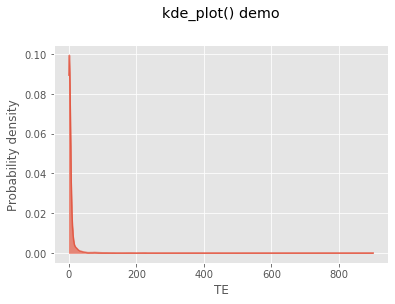

In [41]:
# plot kernel density estimates of A and B on the same axis
fig, ax = kde_plot(df_clean["translation_efficiency"],label="TE")

# make things look nice
plt.xlabel("TE")
plt.ylabel("Probability density")
plt.title("kde_plot() demo",y=1.1)

Then, we can compare the effects of transcriptional and translational control:

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/plastid/lib/python3.8/site-packages/matplotlib/pyplot.py'>

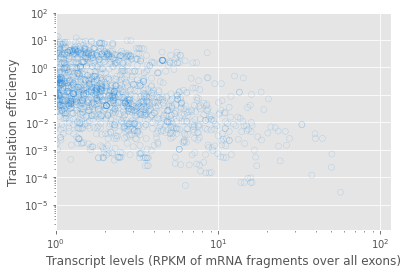

In [27]:
plt.loglog()
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_rpkm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_rpkm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_rpkm"],
            plot_df["translation_efficiency"],
            marker="o",alpha=0.2,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (RPKM of mRNA fragments over all exons)")
plt.ylabel("Translation efficiency")
plt.xlim(1,plt.xlim()[1])
plt.ylim(plt.ylim()[0]/10.0,100)

plt

## Creating a table that shows the read counts for transcript. 

In [38]:
df.to_csv(save_path + "dmel_control_2_te_table.csv", index=False)